In [72]:
import pandas as pd
import torch
from torch.utils.data import Dataset
import os
from torchvision.io import read_image
import matplotlib.pyplot as plt
import numpy as np

In [73]:
class AdversarialDataset(Dataset):
    def __init__(self, annotation_file, categories_file, img_dir, transform=None):
        self.img_dir = img_dir
        annotations = pd.read_csv(annotation_file)
        self.categories = pd.read_csv(categories_file)
        self.images = annotations["ImageId"] + ".png"
        self.labels = annotations["TrueLabel"]
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        image = read_image(img_path)
        label = self.categories.loc[self.categories["CategoryId"] == self.labels[idx], "CategoryName"].values[0]

        if self.transform:
            image = self.transform(image)

        return image, label

In [74]:
def show_image(datarow):
    permuted = torch.permute(datarow[0], (1, 2, 0))
    plt.title(datarow[1])
    plt.imshow(permuted)

In [75]:
dataset = AdversarialDataset("images.csv", "categories.csv", "images")

libpng warning: iCCP: known incorrect sRGB profile


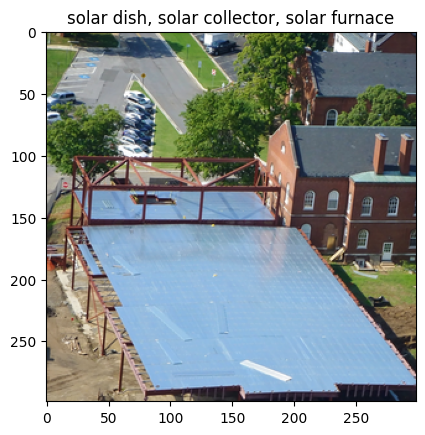

In [76]:
show_image(dataset[100])

In [77]:
len(dataset)

1000